In [1]:
import os
import re
from ast import literal_eval
import numpy as np
from scipy.ndimage import gaussian_filter1d, convolve1d
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from sxfst.utils import plotTraces, plot_set, proc, parse, Screen, PlateData, Cpd

dataDir = 'platereader'
paths = sorted([os.path.join(dataDir, i) for i in os.listdir(dataDir)])
test_paths = list(filter(lambda s : '16032022' in s, paths))
ctrl_paths = list(filter(lambda s : '12032022' in s, paths))

p0 = PlateData(test_paths[0])
p0

platereader/16032022,104721.CSV
User: USER,Path: C:\Program Files (x86)\BMG\CLARIOstar\User\Data\,Test run no.: 2828

 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
A :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
B :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
C :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
D :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
E :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
F :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
G :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
H :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
I :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
J :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
K :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :

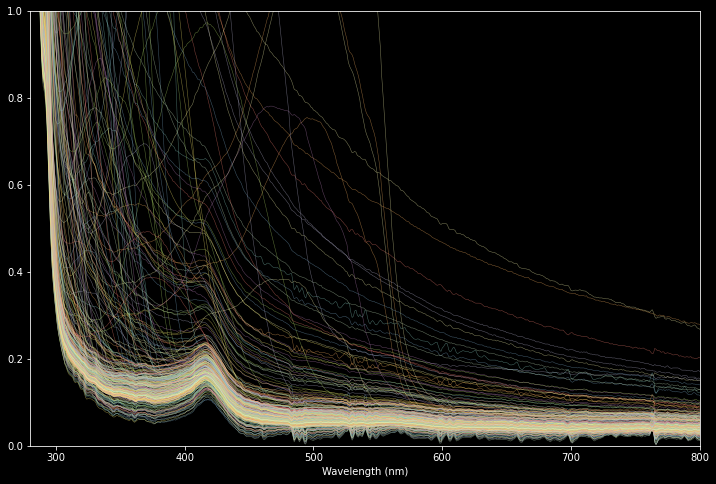

In [2]:
plotTraces(p0.df)

## good/bad 

[`sxiv`](https://github.com/muennich/sxiv) image viewer can open all and output marked images to `stdout`:

``` sxiv -o img/* >> img/good.txt ```

Repeated a few times.

In [3]:
def read(path):
    with open(path) as f:
        return f.read().replace('.png','').splitlines()
    
cats_ = {i.split('.')[0]:read(os.path.join('img', i)) for i in os.listdir('img') if 'txt' in i}
cats = pd.concat([pd.Series(cats_[i], name=i) for i in cats_], axis=1)
cats.head()

,perfect,uv-block,good,medium,ok,scatter,peak,bad
0,S1029,S1005,S1013,S1005,S1013,S1005,S1005,S1042
1,S1047,S1011,S1029,S1013,S1023,S1021,S1011,S1198
2,S1137,S1014,S1047,S1023,S1026,S1023,S1023,S1208
3,S1166,S1021,S1137,S1025,S1028,S1025,S1025,S1210
4,S1168,S1025,S1156,S1026,S1035,S1028,S1042,S1221


In [4]:
overlap = pd.DataFrame([[len(set(cats[i]).intersection(set(cats[j]))) for i in cats] 
                        for j in cats],
                       index = cats.columns,
                       columns = cats.columns)
overlap

,perfect,uv-block,good,medium,ok,scatter,peak,bad
perfect,233,2,230,25,7,1,1,1
uv-block,2,224,21,117,105,118,75,116
good,230,21,520,226,181,21,6,3
medium,25,117,226,572,451,263,67,84
ok,7,105,181,451,503,243,58,59
scatter,1,118,21,263,243,305,36,97
peak,1,75,6,67,58,36,136,76
bad,1,116,3,84,59,97,76,169


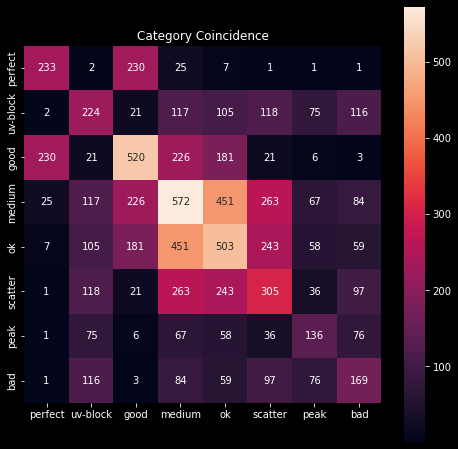

In [5]:
plt.figure(figsize=(8,8))
sns.heatmap(overlap, annot=True, fmt='g', square=True)
plt.title('Category Coincidence')
plt.show()

In [6]:
bad = set(cats['bad'])  | set(cats['scatter']) | set(cats['uv-block'])
medium = set(cats['medium'])  
good = set(cats['good'])  | set(cats['perfect'])
ok = set(good | set(cats['perfect']) | set(cats['ok']))
peak = set(cats['peak'])  
uv_block = set(cats['good'])  
scatter = set(cats['scatter'])  

for i in good.intersection(bad):
    good.discard(i)
for i in medium.intersection(bad):
    medium.discard(i)
for i in ok.intersection(bad):
    ok.discard(i)
for i in ['bad', 'medium', 'scatter','uv-block','peak']:
    for j in good.intersection(set(cats[i])):
        good.discard(j)
for i in [ok, good]:
    for j in bad.intersection(i):
        bad.discard(j)
unclassified = set(re.findall('S[0-9]+', ''.join(os.listdir('img')))).difference(ok | good | bad)

print(f'ok : {len(ok)}')
print(f'good : {len(good)}')
print(f'bad: {len(bad)}')
print(f'medium: {len(medium)}')
print(f'scatter: {len(scatter)}')
print(f'uv_block: {len(uv_block)}')
print(f'peak: {len(peak)}')
print(f'unclassified: {len(unclassified)}')

ok : 543
good : 285
bad: 434
medium: 256
scatter: 305
uv_block: 520
peak: 136
unclassified: 0


## Hack some plotting together

In [7]:
picklist = pd.read_csv('echo/picklists/2022-03-12-00.3-picklist.csv',
                      index_col=0)
wells = {i:picklist.loc[picklist.Cpd == i, :] \
         for i in picklist.Cpd.unique()}
wells["['S1005']"]

,SrcPlate,Cpd,SrcWell,Destination Plate Name,DestWell,Transfer Volume /nl
0,src racks 0..4,['S1005'],A1,dest racks 0..4 0,A1,20.0
1,src racks 0..4,['S1005'],A1,dest racks 0..4 0,A2,605.0
2,src racks 0..4,['S1005'],A1,dest racks 0..4 0,A3,2000.0


In [8]:
data = {i:{'pname':i,
           'x': parse(i)} for i in paths}

In [9]:
data['platereader/12032022,161043.CSV']

{'pname': 'platereader/12032022,161043.CSV',
 'x':        220    221    222    223    224    225    226    227    228    229  \
 A1   1.635  1.604  1.772  2.142  3.500  3.500  2.392  3.500  2.701  2.681   
 B1   3.500  1.852  1.884  2.425  3.500  3.500  2.708  3.500  3.500  3.500   
 C1   2.141  1.907  1.768  2.079  3.500  3.500  3.143  3.500  3.500  3.500   
 D1   3.500  2.017  2.012  2.886  3.500  3.500  3.500  3.500  3.500  3.500   
 E1   3.500  1.817  2.026  3.500  3.500  3.500  2.810  3.500  3.500  3.500   
 ..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
 L24  1.838  1.680  2.150  3.500  3.500  3.500  2.686  2.784  2.628  2.518   
 M24  2.269  1.827  1.536  1.866  2.482  2.710  2.375  3.500  3.146  2.512   
 N24  1.989  1.805  1.658  2.444  3.500  3.500  2.325  3.135  2.686  2.720   
 O24  1.916  1.520  1.634  2.478  3.500  2.980  2.569  3.500  2.650  2.677   
 P24  1.530  1.548  1.728  2.292  2.497  2.366  2.144  3.500  3.500  2.878   
 
      ...   

  0%|          | 0/8 [00:00<?, ?it/s]

dest racks 0..4 0
['A1', 'A2', 'A3']
[20.0, 605.0, 2000.0]
[]
dest racks 0..4 0
['G17', 'G18', 'G19']
[20.0, 605.0, 2000.0]
[]
dest racks 0..4 0
['I1', 'I2', 'I3']
[20.0, 605.0, 2000.0]
[]
dest racks 0..4 0
['J9', 'J10', 'J11']
[20.0, 605.0, 2000.0]
[]
dest racks 0..4 0
['K17', 'K18', 'K19']
[20.0, 605.0, 2000.0]
[]
dest racks 0..4 0
['M1', 'M2', 'M3']
[20.0, 605.0, 2000.0]
[]
dest racks 0..4 0
['O17', 'O18', 'O19']
[20.0, 605.0, 2000.0]
[]
dest racks 0..4 0
['N9', 'N10', 'N11']
[20.0, 605.0, 2000.0]
[]


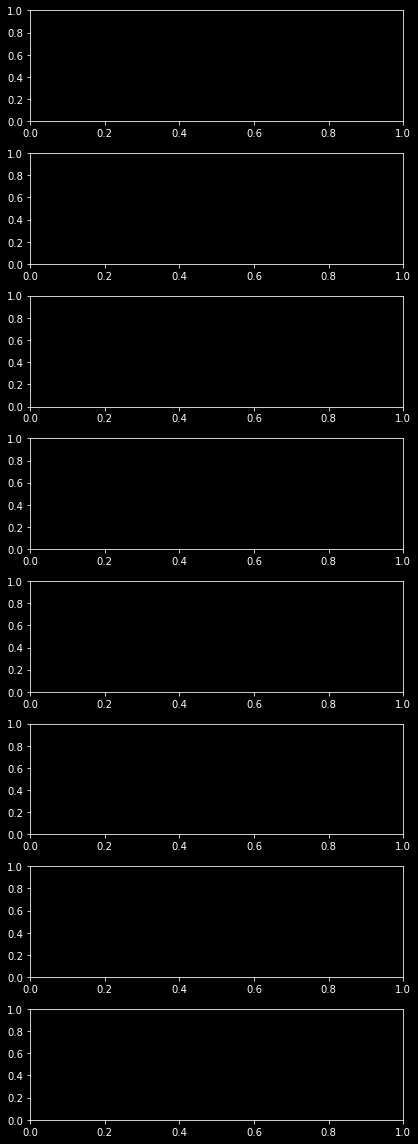

In [11]:
from tqdm.notebook import tqdm

def plot_set(wells, title=''):
    assert len(wells) > 0, 'empty set given'
    if len(wells) <= 8:
        fig, ax = plt.subplots(len(wells),
                               1,
                               figsize=(6,16))
    else:
        fig, ax = plt.subplots(len(wells)//(nRows:=8),
                               nRows,
                               figsize=(16,2))
    for cpd, ax_ in tqdm(zip(wells,
                             ax.flatten()),
                         total=len(wells)):
        _plate = list(set(wells[cpd]['Destination Plate Name']))[0]
        print(_plate)
        _wells = wells[cpd]['DestWell'].to_list()
        print(_wells)
        _vols = wells[cpd]['Transfer Volume /nl'].to_list()
        print(_vols)
        datas_ = [data[i] for i in data if data[i]['pname'] == _plate]
        print(datas_)
        for data_ in datas_:
            data_cpd = data_['x'].loc[_wells,:]
            x = proc(data_cpd)
            for row_, vol_ in zip(x.index, _vols):
                ax_.plot(x.loc[row_,:], c=plt.cm.cool(vol_/2000))
            ax_.set_xlim(280,800)
            ax_.set_title(cpd)
            ax_.set_xlabel('Wavelength (nm)')
            ax_.axis('off')

    plt.title(title)
    plt.tight_layout()
    plt.show()
                                          
subset = {i:wells[i] for i in list(wells.keys())[:8]}
#from sxfst.utils import plot_set
plot_set(subset)

In [ ]:
plot_set(scatter)